# Behavioral analysis of the SAflow MEG dataset


In [49]:
import os
import os.path as op
import numpy as np
import pandas as pd
from scipy.io import loadmat, savemat
from saflow.behav import *
from saflow import LOGS_DIR
import pdb
import matplotlib.gridspec as gridspec
from scipy.stats import ks_2samp
from statannotations.stats.StatTest import StatTest
from statannotations.Annotator import Annotator
from saflow import SUBJ_LIST
import seaborn as sns

LOGS_DIR = "/home/hyruuk/GitHub/cc_saflow/data/behav/"
files_list = os.listdir(LOGS_DIR)
cpt_blocs = [2,3,4,5,6,7]

def get_behavior_dict(files_list, SUBJ_LIST, BLOCS_LIST=[2,3,4,5,6,7]):
    # Get behaviour
    lapse_rates = []
    omission_error_rates = []
    n_rares_list = []
    bloc_list = []
    subject_list = []
    cond_list = []
    splitperf_dict = {'commission_error':[],
                      'omission_error':[],
                      'commission_correct':[],
                      'omission_correct':[]}
    for subject in SUBJ_LIST:
        for bloc in BLOCS_LIST:
            IN_idx, OUT_idx, VTC_raw, VTC_filtered, IN_mask, OUT_mask, performance_dict, df_response = get_VTC_from_file(subject, bloc, files_list, 
                                                                                                                         inout_bounds=inout_bounds, 
                                                                                                                         filt_cutoff=filt_cutoff)
            for loop_idx, inout_idx in enumerate([IN_idx, OUT_idx]):
                # Split behavior into IN/OUT
                commission_error = [x for x in performance_dict['commission_error'] if x in inout_idx]
                omission_error = [x for x in performance_dict['omission_error'] if x in inout_idx]
                commission_correct = [x for x in performance_dict['correct_commission'] if x in inout_idx]
                omission_correct = [x for x in performance_dict['correct_omission'] if x in inout_idx]
                # Compute rates
                try:
                    lapse_rate = len(commission_error) / (len(omission_correct) + len(commission_error))
                except ZeroDivisionError:
                    lapse_rate = np.nan
                omission_error_rate = len(omission_error) / (len(commission_correct) + len(omission_error))

                # Pass to lists to pass to dict (sounds dumb ? it is)
                n_rares_list.append((len(omission_correct) + len(commission_error)))
                lapse_rates.append(lapse_rate)
                omission_error_rates.append(omission_error_rate)
                bloc_list.append(bloc)
                subject_list.append(subject)
                splitperf_dict['commission_error'].append(len(commission_error))
                splitperf_dict['omission_error'].append(len(omission_error))
                splitperf_dict['commission_correct'].append(len(commission_correct))
                splitperf_dict['omission_correct'].append(len(omission_correct))
                if loop_idx == 0:
                    cond_list.append('IN')
                else:
                    cond_list.append('OUT')

    plot_df = pd.DataFrame({
        'lapse_rate':lapse_rates,
        'omission_error_rate':omission_error_rates,
        'commission_error':splitperf_dict['commission_error'],
        'omission_error':splitperf_dict['omission_error'],
        'commission_correct':splitperf_dict['commission_correct'],
        'omission_correct':splitperf_dict['omission_correct'],
        'n_rare':n_rares_list,
        'subject':subject_list,
        'bloc':bloc_list,
        'cond':cond_list
    })        
    return plot_df

def interpolate_RT(RT_raw):
    """Interpolates missing reaction times from the two nearest RTs.

    Parameters
    ----------
    RT_raw : np.array
        Raw reaction times as floats, with 0 for missing RT.

    Returns
    -------
    np.array
        The same array, but with 0s being replaced by the average of the two
        nearest RTs.

    """
    RT_array = RT_raw.copy()
    for idx, val in enumerate(RT_array):
        if val == 0:
            idx_next_val = 1
            try:
                while RT_array[idx + idx_next_val] == 0:  # Find next non-zero value
                    idx_next_val += 1
                if idx == 0:  # If first value is zero, use the next non-zero value
                    RT_array[idx] = RT_array[idx + idx_next_val]
                else:  # else use the average of the two nearest non-zero
                    RT_array[idx] = RT_array[idx - 1] + RT_array[idx + idx_next_val]
            except IndexError:  # If end of file is reached, use the last non-zero
                RT_array[idx] = RT_array[idx - 1]
    return RT_array

def fwhm2sigma(fwhm):
    return fwhm / np.sqrt(8 * np.log(2))

def get_VTC_from_file(
    subject,
    run,
    files_list,
    cpt_blocs=[2, 3, 4, 5, 6, 7],
    inout_bounds=[25, 75],
    filt_cutoff=0.05,
    filt_type='gaussian'
):
    """Short summary.

    Parameters
    ----------
    subject : type
        Description of parameter `subject`.
    run : type
        Description of parameter `run`.
    files_list : type
        Description of parameter `files_list`.
    cpt_blocs : type
        Description of parameter `cpt_blocs`.
    inout_bounds : type
        Description of parameter `inout_bounds`.

    Returns
    -------
    type
        Description of returned object.

    """
    # Find the logfiles belonging to a subject
    subject_logfiles = []
    for bloc in cpt_blocs:
        subject_logfiles.append(
            op.join(LOGS_DIR, find_logfile(subject, bloc, files_list))
        )

    # Load and clean RT arrays
    RT_arrays = []
    RT_to_VTC = []
    for idx_file, logfile in enumerate(subject_logfiles):
        data = loadmat(logfile)
        df_response = pd.DataFrame(data["response"])

        # Replace commission errors by 0
        df_clean, perf_dict = clean_comerr(df_response)
        RT_raw = np.asarray(df_clean.loc[:, 4])
        RT_raw = np.array([x if x != 0 else np.nan for x in RT_raw]) # zeros to nans
        #RT_interpolated = interpolate_RT(RT_raw)
        RT_arrays.append(RT_raw)
        if int(cpt_blocs[idx_file]) == int(run):
            RT_to_VTC = RT_raw
            performance_dict = perf_dict.copy()
            df_response_out = df_response

    # Obtain meand and std across runs
    allruns_RT_array = np.concatenate(RT_arrays)
    subj_mean = np.nanmean(allruns_RT_array)
    subj_std = np.nanstd(allruns_RT_array)

    # New VTC
    VTC_raw = compute_VTC(RT_to_VTC, subj_mean, subj_std)
    #VTC_thresholded = threshold_VTC(VTC_raw, thresh=3)  # Compute VTC remove variability values above threshold
    VTC_raw[np.isnan(VTC_raw)] = 0
    VTC_interpolated = interpolate_RT(VTC_raw)
    if filt_type == 'gaussian':
        filt = signal.gaussian(len(VTC_interpolated), fwhm2sigma(9))
        VTC_filtered = np.convolve(VTC_interpolated, filt, 'same')/sum(filt)
    elif filt_type == 'butterworth':
        b, a = signal.butter(3, filt_cutoff)  # (filt_order,filt_cutoff)
        VTC_filtered = signal.filtfilt(b, a, VTC_interpolated)

    IN_mask = np.ma.masked_where(
        VTC_filtered >= np.quantile(VTC_filtered, inout_bounds[0] / 100), VTC_filtered
    )
    OUT_mask = np.ma.masked_where(
        VTC_filtered < np.quantile(VTC_filtered, inout_bounds[1] / 100), VTC_filtered
    )
    IN_idx = np.where(IN_mask.mask == False)[0]
    OUT_idx = np.where(OUT_mask.mask == False)[0]

    return (
        IN_idx,
        OUT_idx,
        VTC_raw,
        VTC_filtered,
        IN_mask,
        OUT_mask,
        performance_dict,
        df_response_out,
    )

def plot_VTC(VTC_filtered, VTC_raw, IN_mask, OUT_mask, performance_dict, subject_name='?', bloc='?', subgrid_axes=None, fig=None):
    if subgrid_axes == None:
        fig = plt.figure(figsize=(8,5))
        gs = fig.add_gridspec(4, hspace=0, wspace=0)
        ax_vtc = fig.add_subplot(gs[:3])
        ax_odd = fig.add_subplot(gs[3])
    else:
        subgrid_axes.set_xticks([])
        subgrid_axes.set_yticks([])
        gs_inner = gridspec.GridSpecFromSubplotSpec(4,1, hspace=0, wspace=0, subplot_spec=subgrid_axes)
        ax_vtc = fig.add_subplot(gs_inner[:3])
        ax_odd = fig.add_subplot(gs_inner[3])
        
    # VTC plot
    x = np.arange(0, len(VTC_raw))
    raw = ax_vtc.plot(x, VTC_raw)
    plt.setp(raw, linewidth=0.5, color='black')
    lines = ax_vtc.plot(x, IN_mask, x, OUT_mask)
    plt.setp(lines[0], linewidth=2, color='blue')
    plt.setp(lines[1], linewidth=2, color='orange')
    ax_vtc.legend(('VTC', 'IN zone', 'OUT zone'), loc='upper right')
    ax_vtc.set_title(f'VTC plot (sub-{subject_name}, run-0{bloc})')
    ax_vtc.set_ylabel('Standardized variance')

    # Oddball plot
    commission_error = performance_dict['commission_error']
    correct_omission = performance_dict['correct_omission']
    omission_error = performance_dict['omission_error']
    comerr = ax_odd.plot(commission_error, np.zeros(len(commission_error)), '*', color='red')
    corrom = ax_odd.plot(correct_omission, np.zeros(len(correct_omission))+1, '*', color='green')
    #omierr = ax_odd.plot(omission_error, np.zeros(len(omission_error))+2, '*', color='purple')
    ax_odd.set_ylim(-1,8)
    ax_odd.tick_params(left=False, labelleft=False)
    ax_odd.legend(('Commission error', 'Correct omission', 'Omission error'))
    ax_odd.set_xlabel('Trial')
    
    return fig, subgrid_axes

def subject_plot_VTC(subject, cpt_blocs=[2, 3, 4, 5, 6, 7], inout_bounds=[25, 75], filt_cutoff=0.05):
    fig = plt.figure(figsize=(20,15))
    gs_outer = fig.add_gridspec(3, 2)
    for idx, grid in enumerate(gs_outer):
        subgrid_axes = fig.add_subplot(grid)
        IN_idx, OUT_idx, VTC_raw, VTC_filtered, IN_mask, OUT_mask, performance_dict, df_response = get_VTC_from_file(subject, cpt_blocs[idx], files_list, 
                                                                                                        inout_bounds=inout_bounds, filt_cutoff=filt_cutoff)
        plot_VTC(VTC_filtered, 
                 VTC_raw, 
                 IN_mask, OUT_mask, 
                 performance_dict, 
                 subject_name=subject, 
                 bloc=cpt_blocs[idx], 
                 subgrid_axes=subgrid_axes, fig=fig)
    return fig

def performance_plots(files_list, SUBJ_LIST, BLOCS_LIST, inout_bounds, filt_cutoff, stats='ks2samp'):
    # Set stats
    if stats == 'ks2samp':
        custom_long_name = "Kolmogorov-Smirnov test for goodness of fit"
        custom_short_name = "Kolmogorov-Smirnov"
        custom_func = ks_2samp
        pairs = [(('IN', 'OUT'))]
        custom_test = StatTest(custom_func, custom_long_name, custom_short_name)


    plot_df = get_behavior_dict(files_list, SUBJ_LIST, BLOCS_LIST=BLOCS_LIST)

    # Set variables to plot
    variables = ['n_rare', 'lapse_rate', 'omission_error_rate', 'commission_error', 'omission_correct','commission_correct']
    variables_names = ['Number of rares', 'Lapse/Commission error (rate)', 'Omission error (rate)', 'Commission error', 'Correct omission', 'Correct commission']

    fig, axes = plt.subplots(3,2, figsize=(10,12))
    figtitle = f' <{inout_bounds[0]} = IN; >{inout_bounds[1]} = (OUT); f_cutoff = {filt_cutoff}'
    fig.suptitle(figtitle, fontsize=20)
    for idx, ax in enumerate(axes.flat):
        variable = variables[idx]
        ax = sns.barplot(x="cond", y=variable, data=plot_df, ax=ax)
        ax.set_title(f'{variables_names[idx]}')
        ax.xaxis.set_label_coords(0.5,-.035)
        annot = Annotator(ax, pairs, data=plot_df, x="cond", y=variable)
        annot.configure(
            test=custom_test, comparisons_correction="fdr_bh", text_format="star"
        ).apply_test().annotate()

    fig.savefig(f'../reports/figures/behav_barplots_{inout_bounds}_{filt_cutoff}.png')
    return fig


def full_behavior_plot(files_list, SUBJ_LIST, inout_bounds, filt_cutoff, BLOCS_LIST=[2,3,4,5,6,7], stats='ks2samp', subject='32', bloc=2):
    if stats == 'ks2samp':
        # Set stats
        custom_long_name = "Kolmogorov-Smirnov test for goodness of fit"
        custom_short_name = "Kolmogorov-Smirnov"
        custom_func = ks_2samp
        pairs = [(('IN', 'OUT'))]
        custom_test = StatTest(custom_func, custom_long_name, custom_short_name)

    # Get Subject VTC
    IN_idx, OUT_idx, VTC_raw, VTC_filtered, IN_mask, OUT_mask, performance_dict, df_response = get_VTC_from_file(subject, bloc, files_list, 
                                                                                                                 inout_bounds=inout_bounds,
                                                                                                                 filt_cutoff=filt_cutoff)
    plot_df = get_behavior_dict(files_list, SUBJ_LIST, BLOCS_LIST=BLOCS_LIST)

    # Start plotting
    fig = plt.figure(figsize=(20,10))
    gs_outer = fig.add_gridspec(3, 4)
    subgrid_axes_vtc = fig.add_subplot(gs_outer[:2,:3])
    plot_VTC(VTC_filtered, VTC_raw, IN_mask, OUT_mask, performance_dict, subject_name=subject, bloc=bloc, subgrid_axes=subgrid_axes_vtc, fig=fig);

    subgrid_ax_lapse_rate = fig.add_subplot(gs_outer[2,0])
    subgrid_ax_omierr_rate = fig.add_subplot(gs_outer[2,1])
    subgrid_ax_comerr = fig.add_subplot(gs_outer[2,2])

    subgrid_ax_lapse_rate = sns.barplot(x="cond", y='lapse_rate', data=plot_df, ax=subgrid_ax_lapse_rate)
    annot = Annotator(subgrid_ax_lapse_rate, pairs, data=plot_df, x="cond", y='lapse_rate')
    annot.configure(
        test=custom_test, comparisons_correction="fdr_bh", text_format="star"
    ).apply_test().annotate()

    subgrid_ax_omierr_rate = sns.barplot(x="cond", y='omission_error_rate', data=plot_df, ax=subgrid_ax_omierr_rate)
    annot = Annotator(subgrid_ax_omierr_rate, pairs, data=plot_df, x="cond", y='omission_error_rate')
    annot.configure(
        test=custom_test, comparisons_correction="fdr_bh", text_format="star"
    ).apply_test().annotate()

    subgrid_ax_comerr = sns.barplot(x="cond", y='commission_error', data=plot_df, ax=subgrid_ax_comerr)
    annot = Annotator(subgrid_ax_comerr, pairs, data=plot_df, x="cond", y='commission_error')
    annot.configure(
        test=custom_test, comparisons_correction="fdr_bh", text_format="star"
    ).apply_test().annotate()

    figtitle = f' <{inout_bounds[0]} = IN; >{inout_bounds[1]} = OUT; f_cutoff = {filt_cutoff}'
    fig.suptitle(figtitle, fontsize=16, y=0.94, x=0.42)
    fig.savefig(f'../reports/figures/behav_fullplot_{inout_bounds}_{filt_cutoff}.jpg')
    return fig

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

IN vs. OUT: Kolmogorov-Smirnov test for goodness of fit with Benjamini-Hochberg correction, P_val:7.606e-07 Stat=2.760e-01
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

IN vs. OUT: Kolmogorov-Smirnov test for goodness of fit with Benjamini-Hochberg correction, P_val:1.459e-18 Stat=4.583e-01
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

IN vs. OUT: Kolmogorov-Smirnov test for goodness of fit with Benjamini-Hochberg correction, P_val:4.520e-12 Stat=3.698e-01


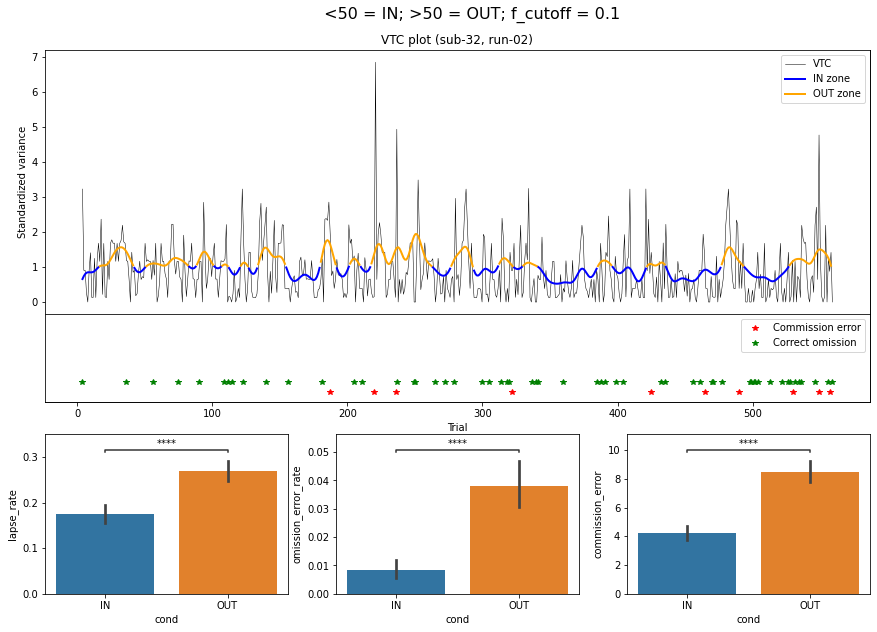

In [55]:
# Bigass behavioral plot

subject = '32'
bloc = 2
inout_bounds = [50,50]
filt_cutoff = 0.1

full_behavior_plot(files_list, SUBJ_LIST, inout_bounds, filt_cutoff, stats='ks2samp', subject=subject, bloc=bloc);

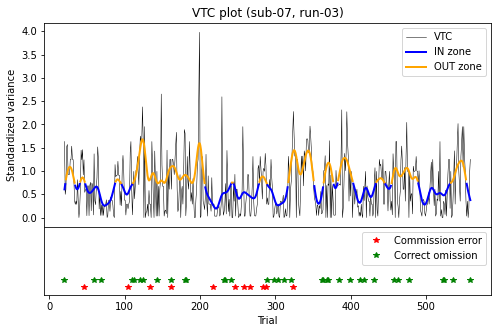

In [36]:
# Simple plot
subject = '07'
bloc = 3
inout_bounds = [50,50]
filt_cutoff = 0.1


IN_idx, OUT_idx, VTC_raw, VTC_filtered, IN_mask, OUT_mask, performance_dict, df_response = get_VTC_from_file(subject, bloc, files_list, 
                                                                                                             inout_bounds=inout_bounds, 
                                                                                                             filt_cutoff=filt_cutoff)
plot_VTC(VTC_filtered, VTC_raw, IN_mask, OUT_mask, performance_dict, subject_name=subject, bloc=bloc);

In [41]:
# Subject-wise plots

IMG_DIR = '/home/hyruuk/GitHub/cc_saflow/reports/figures/VTC_plots/'
os.makedirs(IMG_DIR, exist_ok=True)

for subject in SUBJ_LIST:
    fig = subject_plot_VTC(subject)
    fig_name = f'sub-{subject}_VTC_plots.jpg'
    fig.savefig(op.join(IMG_DIR, fig_name))
    plt.close()



p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

IN vs. OUT: Kolmogorov-Smirnov test for goodness of fit with Benjamini-Hochberg correction, P_val:3.954e-24 Stat=5.208e-01
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

IN vs. OUT: Kolmogorov-Smirnov test for goodness of fit with Benjamini-Hochberg correction, P_val:7.606e-07 Stat=2.760e-01
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

IN vs. OUT: Kolmogorov-Smirnov test for goodness of fit with Benjamini-Hochberg correction, P_val:1.459e-18 Stat=4.583e-01
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
  

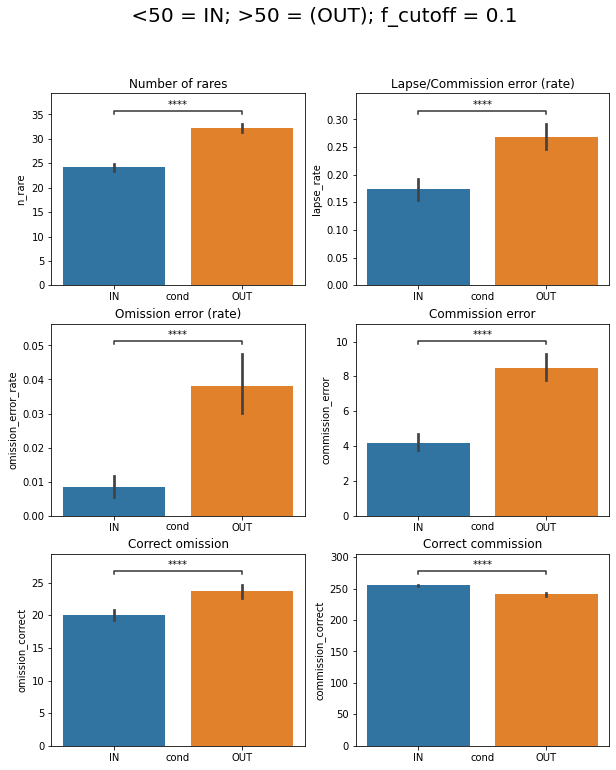

In [48]:
# Performance figures
inout_bounds = [50,50]
filt_cutoff = 0.1    

performance_plots(files_list, SUBJ_LIST, [2,3,4,5,6,7], inout_bounds, filt_cutoff, stats='ks2samp')

In [ ]:
fig = plt.figure(figsize=(30,10))
ax = plt.subplot(1,1,1)
ax = sns.barplot(x="subject", hue='cond', y="n_rare", data=plot_df, ax=ax)

In [ ]:
# Look at distributions of filtered VTC values

In [ ]:
# Check Bastien Sackur for markov chains - mind wandering

In [ ]:
# Just check the first three runs of each subject

In [ ]:
# Try removing trials surrounding Commission Errors